In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [36]:
import yfinance as yf
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import risk_models
from pypfopt import black_litterman,BlackLittermanModel,plotting
from pypfopt import DiscreteAllocation

In [5]:
pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 12.4 MB/s eta 0:00:00


In [7]:
#Create a Portfolio
symbols = [
    'AAPL',
    'MSFT',
    'META',
    'AMZN',
    'XOM',
    'UNH',
    'JNJ',
    'V',
    'HD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'F',
    'MAR',
    'O',
    'HSY'
]

In [8]:
portfolio=yf.download(symbols,start='2018-01-01',end='2023-02-28')['Close']
portfolio.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


Ticker,AAPL,ABBV,AMZN,CAT,DIS,F,HD,HSY,JNJ,KO,LMT,MAR,META,MSFT,O,T,UNH,UPS,V,XOM
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.479839,71.013672,59.450500,133.353867,107.399284,8.594529,157.680313,94.892509,113.850288,36.272217,262.917694,126.079849,180.568985,79.474159,39.007507,16.615959,198.535278,95.981415,108.921043,60.593204
2018-01-03,40.472790,72.124947,60.209999,133.557693,107.860390,8.662417,158.502136,94.494698,114.937843,36.192562,265.121399,128.625015,183.803726,79.844032,38.904167,16.232254,200.617935,98.107933,110.005386,61.783276
2018-01-04,40.660786,71.713615,60.479500,135.391876,107.812363,8.811769,159.760010,95.154930,114.929688,36.702328,269.669281,127.918015,183.465332,80.546768,38.063656,16.383146,201.488708,98.744339,110.414398,61.868774
2018-01-05,41.123722,72.961998,61.457001,137.531784,107.226372,8.961123,161.428802,95.611977,115.878212,36.694355,272.112396,126.692574,185.973511,81.545403,38.036110,16.443504,205.330887,99.047035,113.058708,61.818897
2018-01-08,40.970963,71.792976,62.343498,140.987915,105.689346,8.927178,161.043030,96.543037,116.025391,36.638603,270.857910,128.521317,187.396805,81.628601,38.084320,16.490929,201.766983,100.250000,113.515282,62.096817


In [9]:
market_prices=yf.download('SPY',start='2018-01-01',end='2023-02-28')['Close']
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2018-01-02,239.274017
2018-01-03,240.787445
2018-01-04,241.802307
2018-01-05,243.413712
2018-01-08,243.858780


In [16]:
#grabbing market cap for each stock in the portfolio
marketcaps={}
for stock in symbols:
  stock_info=yf.Ticker(stock)
  # Use the stock ticker as the key
  marketcaps[stock]=stock_info.info['marketCap']

# Convert marketcaps to a pandas Series with the correct index
marketcaps = pd.Series(marketcaps, index=symbols)
marketcaps

,0
AAPL,2959053160448
MSFT,2734069121024
META,1270579855360
AMZN,1831806435328
XOM,462459994112
UNH,415379849216
JNJ,379479097344
V,635820965888
HD,352904085504
ABBV,306015862784


In [17]:
#calc sigma and delta to get implied market returns
S=risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta=black_litterman.market_implied_risk_aversion(market_prices)
delta

np.float64(2.526889403302398)

<Axes: xlabel='Ticker', ylabel='Ticker'>

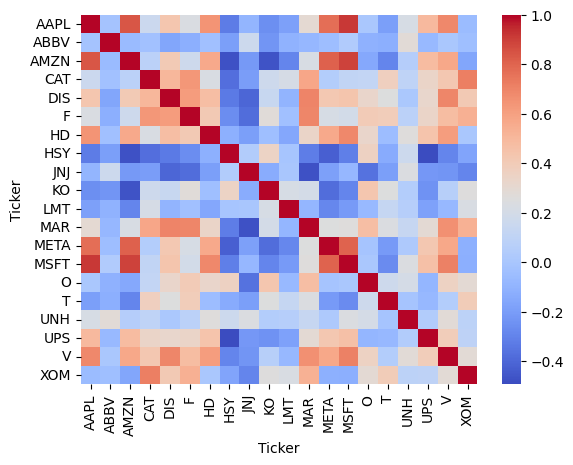

In [18]:
sns.heatmap(S.corr(),cmap='coolwarm')

In [19]:
market_prior=black_litterman.market_implied_prior_returns(marketcaps,delta,S)
market_prior

,0
Ticker,
AAPL,0.190054
ABBV,0.082431
AMZN,0.186055
CAT,0.111370
DIS,0.126430
F,0.129350
HD,0.128199
HSY,0.059069
JNJ,0.066846


<Axes: ylabel='Ticker'>

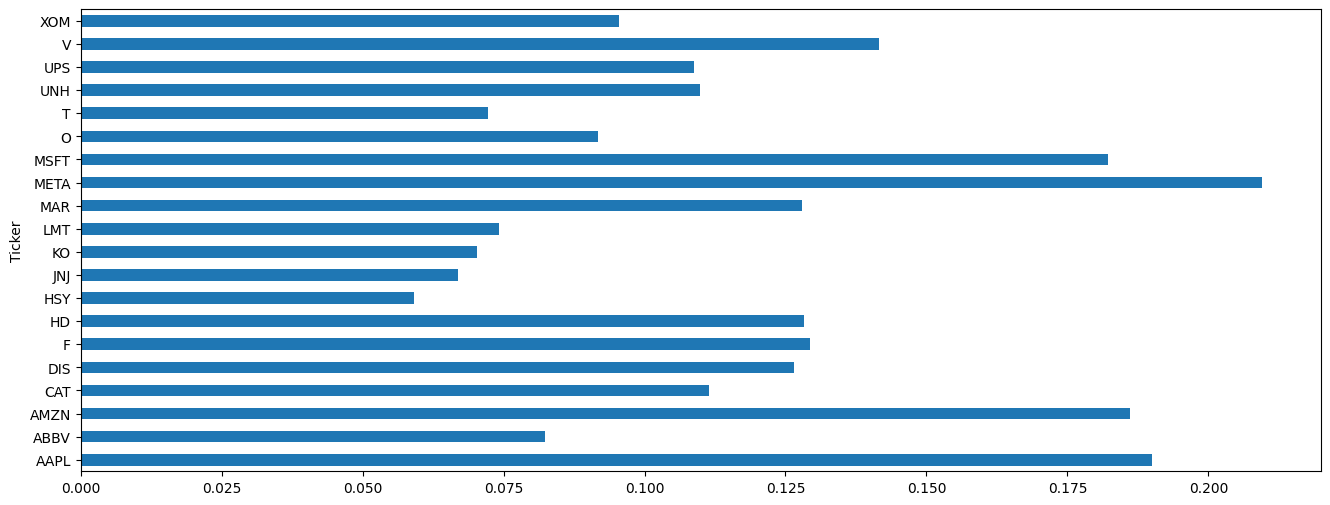

In [21]:
market_prior.plot.barh(figsize=(16,6))#market prior tells us how much are we goign to be compensated per the risk we are going to take for allocating on this stock

In [22]:
#Integrating our views

In [24]:
#You don't have to provide views on all the assets
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'META':0.05,
    'AMZN':0.30,
    'XOM':0.02,
    'UNH':0.01,
    'JNJ':0.15,
    'V':0.09,
    'HD':0.16,
    'ABBV':0.07,
    'KO':0.01,
    'DIS':-0.23,
    'T':0.16,
    'UPS':0.10,
    'LMT':-0.09,
    'CAT':0.30,
    'F':0.16,
    'MAR':-0.08,
    'O':0.30,
    'HSY':-0.26
}

bl = BlackLittermanModel(S,pi=market_prior,absolute_views=viewdict)

## we are creating confidence intervals which we think will contain the true returns 68% of the time[within 1 std dev]

In [25]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
]

In [26]:
variances=[]
for lb,ub in intervals:
  sigma=(ub-lb)/2
  variances.append(sigma**2)

print(variances)
omega=np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


In [27]:
bl=BlackLittermanModel(S,pi='market',absolute_views=viewdict,omega=omega,market_caps=marketcaps)#delta is the market excess return divided by variance

In [29]:
#posterior estimate of returns
ret_bl=bl.bl_returns()
ret_bl

,0
Ticker,
AAPL,0.122365
ABBV,0.058127
AMZN,0.182286
CAT,0.184253
DIS,0.040088
F,0.127286
HD,0.086310
HSY,0.006326
JNJ,0.079721


In [32]:
rets_df=pd.DataFrame([market_prior,ret_bl,pd.Series(viewdict)],index=['Prior','Posterior','Views']).T
rets_df

,Prior,Posterior,Views
AAPL,0.190054,0.122365,0.10
ABBV,0.082431,0.058127,0.07
AMZN,0.186055,0.182286,0.30
CAT,0.111370,0.184253,0.30
DIS,0.126430,0.040088,-0.23
F,0.129350,0.127286,0.16
HD,0.128199,0.086310,0.16
HSY,0.059069,0.006326,-0.26
JNJ,0.066846,0.079721,0.15
KO,0.070275,0.029722,0.01


<Axes: >

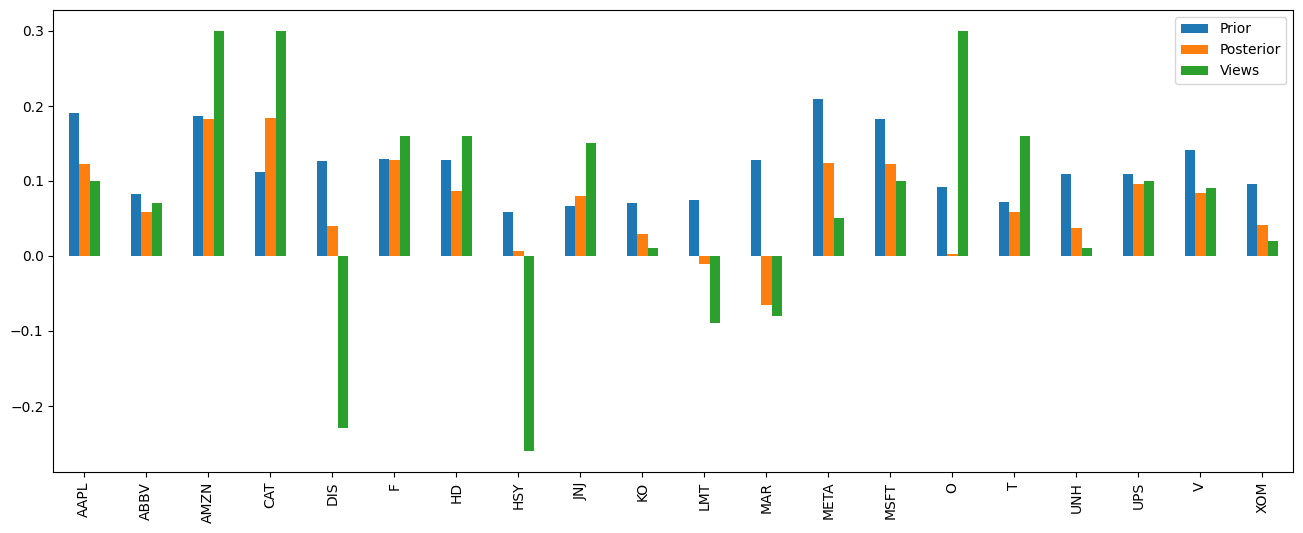

In [33]:
rets_df.plot.bar(figsize=(16,6))

## lets see actual allocation based on Efficient Frontier

In [34]:
S_bl=bl.bl_cov()

In [37]:
ef=EfficientFrontier(ret_bl,S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights=ef.clean_weights()
weights

OrderedDict([('AAPL', 0.08514),
             ('ABBV', 0.03758),
             ('AMZN', 0.15466),
             ('CAT', 0.16564),
             ('DIS', 0.0),
             ('F', 0.08943),
             ('HD', 0.05454),
             ('HSY', 0.0),
             ('JNJ', 0.06937),
             ('KO', 0.00788),
             ('LMT', 0.0),
             ('MAR', 0.0),
             ('META', 0.07816),
             ('MSFT', 0.08723),
             ('O', 0.0),
             ('T', 0.03887),
             ('UNH', 0.00538),
             ('UPS', 0.06929),
             ('V', 0.04931),
             ('XOM', 0.00751)])

<Axes: >

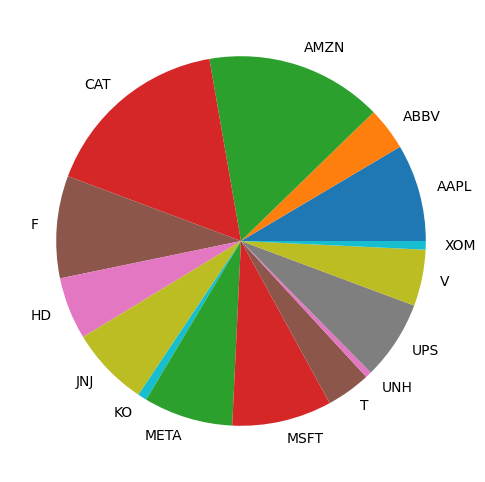

In [39]:
pd.Series(weights).plot.pie(figsize=(16,6))

Expected annual return: 12.7%
Annual volatility: 23.3%
Sharpe Ratio: 0.55


(np.float64(0.12719168117448856),
 np.float64(0.23265025144871235),
 np.float64(0.5467076883969236))

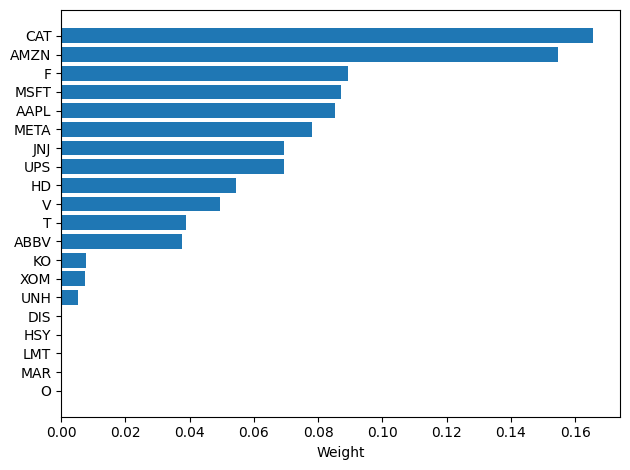

In [40]:
from pypfopt.plotting import plot_weights

#max sharpe
ef=EfficientFrontier(ret_bl,S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights=ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose=True,risk_free_rate=0.009)